<a href="https://colab.research.google.com/github/rajarathnambalakrishnan/Image-Recognition-for-Autonomous-Driving/blob/master/Capstonev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL

Tensorflow version : 2.1.0


In [0]:
import glob

## Overview of Modules required:
1. Feature extractor CNN model with tweaked top layers for detection specific output.
2. Process images and annotations for detection task.
3. Modules of detection algorithm

In [0]:

labels = ('person','rider','bike','bus','car','motor','truck','train')
im_h = 512
im_w = 512
num_anchors = 5
num_class = len(labels)
anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
grid_w = 16
grid_h = 16

## Pre-Trained Feature Extractor and Additional Detection Layers

In [0]:
input_tensor = Input((512, 512, 3), dtype='float32')
base_model = keras.applications.resnet.ResNet50(input_tensor = input_tensor, weights="imagenet", include_top = False)

94773248/94765736 [==============================] - 2s 0us/step


In [0]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
dp = Dropout(rate=0.7)(base_model.output)
bn = BatchNormalization()(dp)
lr = LeakyReLU(alpha=0.1)(bn)
dl = Conv2D(num_anchors*(4+1+num_class),(1,1),strides=(1,1), padding = 'same', name='detection_layer')(lr)
output = Reshape((grid_h, grid_w, num_anchors, 4+1+num_class))(dl)
model = keras.Model(inputs = base_model.input, outputs=output)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
# freeze base layers
for layer in base_model.layers:
  layer.trainable = False

In [0]:
import os


## Modules of the algorithm

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
model.load_weights('/content/drive/My Drive/Google Colab Datasets/resnet_yolo_95.h5')


## Dataset loading: Images + Annotations

In [0]:
#load the bboxes data
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
boxes = np.load('/content/drive/My Drive/Google Colab Datasets/boxes_new.npy')
np.load = np_load_old
boxes = list(boxes)

# data for first 1000 images only
boxes = boxes[:1000]

# load the image data
#images = np.load('/content/drive/My Drive/Google Colab Datasets/v1/image_data.npy')

# convert bbox array to have same shape for each image data
# accomodate for the maximum annotations for the dataset 
# put zeros for extra annotations

ann_shape = []
for i in boxes:
  ann_shape.append(i.shape[0]) # 0th position holds the number of annotations per image

max_ann_shape = max(ann_shape)
equal_shape_boxes = np.zeros((1000,max_ann_shape,num_anchors))

for index, box in enumerate(boxes):
  equal_shape_boxes[index,:box.shape[0],:num_anchors] = box # saving the annotations for each image and allowing remaining annotations to be zero 



# prepare and load the image data
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
fn = np.load('/content/drive/My Drive/Google Colab Datasets/fns.npy')
np.load = np_load_old



fns = fn.copy()
fns = ['/content/drive/My Drive/Google Colab Datasets/train/'+ i for i in fns]
fns = fns[:1000]
file_names = np.array(fns)

In [0]:
def parse_image(obj, bboxes):
  img_obj = tf.io.read_file(obj)
  imgs = tf.image.decode_png(img_obj, channels=3)
  imgs = tf.image.convert_image_dtype(imgs, tf.float32)
  imgs = tf.image.resize(imgs,[512,512])
  return imgs, bboxes

dataset = tf.data.Dataset.from_tensor_slices((file_names, equal_shape_boxes))    
dataset = dataset.shuffle(len(file_names))
dataset = dataset.repeat()
dataset = dataset.map(parse_image, num_parallel_calls=6)
dataset = dataset.batch(25)
dataset = dataset.prefetch(10)


<Figure size 144x144 with 0 Axes>

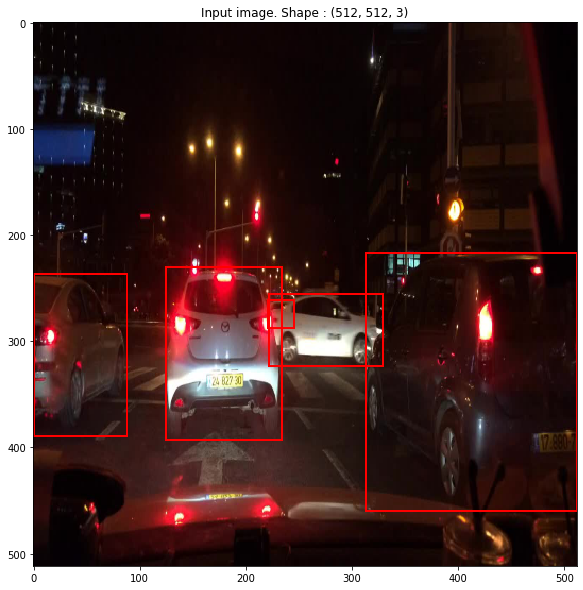

In [0]:
#testing the image and bbox mapping

for batch in dataset:
  img = batch[0][0]
  label = batch[1][0]
  plt.figure(figsize=(2,2))
  f, (ax1) = plt.subplots(1,1, figsize=(10, 10))
  ax1.imshow(img)
  ax1.set_title('Input image. Shape : {}'.format(img.shape))
  for i in range(label.shape[0]):

    box = label[i,:]
    box = box.numpy()
    x = box[0]*(512/1280)
    y = box[1]*(512/720)
    w = (box[2] - box[0])*(512/1280)
    h = (box[3] - box[1])*(512/720)
    if box[4] == 1:

      color = (0, 1, 0)
    else:
      color = (1, 0, 0)
    rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor=color,facecolor='none')
    ax1.add_patch(rect)
  break

In [0]:
# create ground truth labels for training and processing results 

h_norm = 1/720
w_norm = 1/1280
anchors = np.array(anchors)
anchors = anchors.reshape(num_anchors, 2)

In [0]:
#
  all_matching_boxes = []
  all_detector_masks = []
  all_bboxes = []

  for i in range(equal_shape_boxes.shape[0]):

    detector_mask = np.zeros((grid_w,grid_h,num_anchors,1))
    matching_boxes = np.zeros((grid_w,grid_h,num_anchors,5))
    grid_boxes = np.zeros(equal_shape_boxes.shape[1:])
    
    for j,b in  enumerate(equal_shape_boxes[i,:,:]):
      
      #convert pixel values annotations to yolo output resolution 
      w = (b[2] - b[0]) * w_norm * grid_w
      h = (b[3] - b[1]) * h_norm * grid_h   
      x = ((b[0] + b[2]) / 2) * w_norm * grid_w
      y = ((b[1] + b[3]) / 2) * h_norm * grid_h
      grid_boxes[j,...] = np.array([x,y,w,h,b[4]])

      if x > 0: # if box annotation exists

        # picking the best anchor for given bbox
        iou_best = 0
        anchor_best = 0
        for k in range(num_anchors):
          intersection = np.minimum(w,anchors[k,0]) * np.minimum(h,anchors[k,1])
          union = (anchors[k,0] * anchors[k,1]) + (w * h) - intersection
          iou = intersection / union

          if iou > iou_best:
            iou_best = iou
            anchor_best = k
        if iou_best > 0:
          o_x = np.floor(x).astype('int')
          o_y = np.floor(y).astype('int')
          detector_mask[o_y, o_x, anchor_best] = 1
          matching_boxes[o_y, o_x, anchor_best] = grid_boxes[j]

    all_matching_boxes.append(matching_boxes)
    all_detector_masks.append(detector_mask)
    all_bboxes.append(grid_boxes)
  
  detector_masks = tf.convert_to_tensor(np.array(all_detector_masks), dtype='float32')
  matching_bboxes = tf.convert_to_tensor(np.array(all_matching_boxes),dtype='float32')
  bboxes = tf.convert_to_tensor(np.array(all_bboxes), dtype='float32')
  

In [0]:
matching_classes = K.cast(matching_bboxes[..., 4], 'int32') 
class_one_hot = K.one_hot(matching_classes, num_class + 1)[:,:,:,:,1:]
class_one_hot = tf.cast(class_one_hot, dtype='float32')

In [0]:
def parse_image_1(obj, detector_masks, matching_bboxes, class_one_hot, bboxes):
  img_obj = tf.io.read_file(obj)
  imgs = tf.image.decode_png(img_obj, channels=3)
  imgs = tf.image.convert_image_dtype(imgs, tf.float32)
  imgs = tf.image.resize(imgs,[512,512])
  return imgs, detector_masks, matching_bboxes, class_one_hot, bboxes

dataset_1 = tf.data.Dataset.from_tensor_slices((file_names,detector_masks, matching_bboxes, class_one_hot, bboxes))
dataset_1 = dataset_1.map(parse_image_1, num_parallel_calls=6)
dataset_1 = dataset_1.shuffle(len(file_names), reshuffle_each_iteration=True)
dataset_1 = dataset_1.repeat()
dataset_1 = dataset_1.batch(25)
dataset_1 = dataset_1.prefetch(10)


In [0]:
detector_masks.shape

TensorShape([1000, 16, 16, 5, 1])

In [0]:
bboxes.shape

TensorShape([1000, 44, 5])

In [0]:
class_one_hot.shape

TensorShape([1000, 16, 16, 5, 8])

In [0]:
matching_bboxes.shape

TensorShape([1000, 16, 16, 5, 5])

In [0]:
def iou(x1, y1, w1, h1, x2, y2, w2, h2):
    '''
    Calculate IOU between box1 and box2

    Parameters
    ----------
    - x, y : box center coords
    - w : box width
    - h : box height
    
    Returns
    -------
    - IOU
    '''   
    xmin1 = x1 - 0.5*w1
    xmax1 = x1 + 0.5*w1
    ymin1 = y1 - 0.5*h1
    ymax1 = y1 + 0.5*h1
    xmin2 = x2 - 0.5*w2
    xmax2 = x2 + 0.5*w2
    ymin2 = y2 - 0.5*h2
    ymax2 = y2 + 0.5*h2
    interx = np.minimum(xmax1, xmax2) - np.minimum(xmin1, xmin2)
    intery = np.minimum(ymax1, ymax2) - np.minimum(ymin1, ymin2)
    inter = interx * intery
    union = w1*h1 + w2*h2 - inter
    iou = inter / (union + 1e-6)
    return iou

In [0]:
def train_batch(dataset):
  for batch in dataset:
    (imgs, detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid) = batch[0],batch[1],batch[2],batch[3],batch[4]
    batch = (imgs, detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid)
    yield batch

In [0]:
train_gen = train_batch(dataset_1)

In [0]:
# loss

def yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid, y_pred):
    '''
    Calculate YOLO V2 loss from prediction (y_pred) and ground truth tensors (detector_mask,
    matching_true_boxes, class_one_hot, true_boxes_grid,)

    Parameters
    ----------
    - detector_mask : tensor, shape (batch, size, GRID_W, GRID_H, anchors_count, 1)
        1 if bounding box detected by grid cell, else 0
    - matching_true_boxes : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, 5)
        Contains adjusted coords of bounding box in YOLO format
    - class_one_hot : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, class_count)
        One hot representation of bounding box label
    - true_boxes_grid : annotations : tensor (shape : batch_size, max annot, 5)
        true_boxes_grid format : x, y, w, h, c (coords unit : grid cell)
    - y_pred : prediction from model. tensor (shape : batch_size, GRID_W, GRID_H, anchors count, (5 + labels count)
    - info : boolean. True to get some infox about loss value
    
    Returns
    -------
    - loss : scalar
    - sub_loss : sub loss list : coords loss, class loss and conf loss : scalar
    '''
    
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(16), [16]), (1, 16, 16, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [y_pred.shape[0], 1, 1, 5, 1])
    
    # coordinate loss
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2]) # adjust coords between 0 and 1
    pred_xy = (pred_xy + coords) # add cell coord for comparaison with ground truth. New coords in grid cell unit
    pred_wh = K.exp(y_pred[:,:,:,:,2:4]) * anchors # adjust width and height for comparaison with ground truth. New coords in grid cell unit
    #pred_wh = (pred_wh * anchors) # unit : grid cell
    nb_detector_mask = K.sum(tf.cast(detector_mask > 0.0, tf.float32))
    xy_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(matching_true_boxes[...,:2] - pred_xy)) / (nb_detector_mask + 1e-6) # Non /2
    wh_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(K.sqrt(matching_true_boxes[...,2:4]) - 
                                                            K.sqrt(pred_wh))) / (nb_detector_mask + 1e-6)
    coord_loss = xy_loss + wh_loss
    
    # class loss    
    pred_box_class = y_pred[..., 5:]
    true_box_class = tf.argmax(class_one_hot, -1)
    #class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    class_loss = K.sparse_categorical_crossentropy(target=true_box_class, output=pred_box_class, from_logits=True)
    class_loss = K.expand_dims(class_loss, -1) * detector_mask
    class_loss = LAMBDA_CLASS * K.sum(class_loss) / (nb_detector_mask + 1e-6)
    
    # confidence loss
    pred_conf = K.sigmoid(y_pred[...,4:5])
    # for each detector : iou between prediction and ground truth
    x1 = matching_true_boxes[...,0]
    y1 = matching_true_boxes[...,1]
    w1 = matching_true_boxes[...,2]
    h1 = matching_true_boxes[...,3]
    x2 = pred_xy[...,0]
    y2 = pred_xy[...,1]
    w2 = pred_wh[...,0]
    h2 = pred_wh[...,1]
    ious = iou(x1, y1, w1, h1, x2, y2, w2, h2)
    ious = K.expand_dims(ious, -1)
     
    # for each detector : best ious between prediction and true_boxes (every bounding box of image)
    pred_xy = K.expand_dims(pred_xy, 4) # shape : m, GRID_W, GRID_H, BOX, 1, 2 
    pred_wh = K.expand_dims(pred_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half
    true_boxe_shape = K.int_shape(true_boxes_grid)
    true_boxes_grid = K.reshape(true_boxes_grid, [true_boxe_shape[0], 1, 1, 1, true_boxe_shape[1], true_boxe_shape[2]])
    true_xy = true_boxes_grid[...,0:2]
    true_wh = true_boxes_grid[...,2:4]
    true_wh_half = true_wh * 0.5
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half
    intersect_mins = K.maximum(pred_mins, true_mins) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2 
    intersect_maxes = K.minimum(pred_maxes, true_maxes) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, 1, 1
    true_areas = true_wh[..., 0] * true_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
    best_ious = K.expand_dims(best_ious) # shape : m, GRID_W, GRID_H, BOX, 1
    
    # no object confidence loss
    no_object_detection = K.cast(best_ious < 0.6, K.dtype(best_ious)) 
    noobj_mask = no_object_detection * (1 - detector_mask)
    nb_noobj_mask  = K.sum(tf.cast(noobj_mask  > 0.0, tf.float32))
    
    noobject_loss =  LAMBDA_NOOBJECT * K.sum(noobj_mask * K.square(-pred_conf)) / (nb_noobj_mask + 1e-6)
    # object confidence loss
    object_loss = LAMBDA_OBJECT * K.sum(detector_mask * K.square(ious - pred_conf)) / (nb_detector_mask + 1e-6)
    # total confidence loss
    conf_loss = noobject_loss + object_loss
    
    # total loss
    loss = conf_loss + class_loss + coord_loss
    sub_loss = [conf_loss, class_loss, coord_loss]  
    
#     # 'triple' mask
#     true_box_conf_IOU = ious * detector_mask
#     conf_mask = noobj_mask * LAMBDA_NOOBJECT
#     conf_mask = conf_mask + detector_mask * LAMBDA_OBJECT
#     nb_conf_box  = K.sum(tf.to_float(conf_mask  > 0.0))
#     conf_loss = K.sum(K.square(true_box_conf_IOU - pred_conf) * conf_mask)  / (nb_conf_box  + 1e-6) 
    
#     # total loss
#     loss = conf_loss /2. + class_loss + coord_loss /2.
#     sub_loss = [conf_loss /2., class_loss, coord_loss /2.]

              
    return loss, sub_loss

In [0]:
# gradients
def grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=True):
    with tf.GradientTape() as tape:
        y_pred = model(img, training)
        loss, sub_loss = yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes, y_pred)
    return loss, sub_loss, tape.gradient(loss, model.trainable_variables)

# save weights
def save_best_weights(model, name, epoch):

    name = name + '_' + str(epoch+1) + '.h5'
    path_name = os.path.join('/content/drive/My Drive/Google Colab Datasets/', name)
    model.save_weights(path_name)

# log (tensorboard)
#def log_loss(loss, val_loss, step):
    #tf.summary.scalar('loss', loss, step)
    #tf.summary.scalar('val_loss', val_loss, step)

In [0]:
# training
def train(epochs, model, train_dataset, steps_per_epoch_train, train_name = 'train'):
    '''
    Train YOLO model for n epochs.
    Eval loss on training and validation dataset.
    Log training loss and validation loss for tensorboard.
    Save best weights during training (according to validation loss).

    Parameters
    ----------
    - epochs : integer, number of epochs to train the model.
    - model : YOLO model.
    - train_dataset : YOLO ground truth and image generator from training dataset.
    - val_dataset : YOLO ground truth and image generator from validation dataset.
    - steps_per_epoch_train : integer, number of batch to complete one epoch for train_dataset.
    - steps_per_epoch_val : integer, number of batch to complete one epoch for val_dataset.
    - train_name : string, training name used to log loss and save weights.
    
    Notes :
    - train_dataset and val_dataset generate YOLO ground truth tensors : detector_mask,
      matching_true_boxes, class_one_hot, true_boxes_grid. Shape of these tensors (batch size, tensor shape).
    - steps per epoch = number of images in dataset // batch size of dataset
    
    Returns
    -------
    - loss history : [train_loss_history, val_loss_history] : list of average loss for each epoch.
    '''
    num_epochs = epochs
    steps_per_epoch_train = steps_per_epoch_train
    #steps_per_epoch_val = steps_per_epoch_val
    train_loss_history = []
    val_loss_history = []
    best_val_loss = 1e6
    
    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    # log (tensorboard)
    summary_writer = tf.summary.create_file_writer(os.path.join('logs/', train_name), flush_millis=20000)
    summary_writer.set_as_default()
    
    # training
    for epoch in range(num_epochs):
        epoch_loss = []
        epoch_val_loss = []
        epoch_val_sub_loss = []
        print('Epoch {} :'.format(epoch))
        # train
        for batch_idx in range(steps_per_epoch_train): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(train_dataset)
            loss, _, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss.append(loss)
            print('-', end='')
        print(' | ', end='')
        # val
        '''for batch_idx in range(steps_per_epoch_val): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(val_dataset)
            loss, sub_loss, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=False)
            epoch_val_loss.append(loss)
            epoch_val_sub_loss.append(sub_loss)
            print('-', end='')'''

        loss_avg = np.mean(np.array(epoch_loss))
        val_loss_avg = 0#np.mean(np.array(epoch_val_loss))
        sub_loss_avg = 0#np.mean(np.array(epoch_val_sub_loss), axis=0)
        train_loss_history.append(loss_avg)
        #val_loss_history.append(val_loss_avg)
        
        # log
        #log_loss(loss_avg, val_loss_avg, epoch)
        
        #save
        if (epoch+1) % 5 == 0:

          save_best_weights(model, train_name, epoch)
        
        print(' loss = {:.4f}'.format(loss_avg))
        
    return [train_loss_history]


In [0]:
LAMBDA_NOOBJECT  = 1
LAMBDA_OBJECT    = 5
LAMBDA_CLASS     = 1
LAMBDA_COORD     = 1

In [0]:
results = train(100, model, train_gen, 40, 'resnet_yolo')
plt.plot(results[0])

Epoch 0 :
-WARNING:tensorflow:Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
-WARNING:tensorflow:Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
-WARNING:tensorflow:Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
------------------------------------- |  loss = 17720.0703
Epoch 1 :
---------------------------------------- |  loss = 6972.6260
Epoch 2 :
---------------------------------------- |  loss = 6393.5400
Epoch 3 :
---------------------------------------- |  loss = 102729.0469
Epoch 4 :
---------------------------------------- |  loss = 30017.0742
Epoch 5 :
---------------------------------------- |  loss = 515810.3438
Epoch 6 :
---------------------------------------- |  loss = 74201016.0000
Epoch 7 :
------------

KeyboardInterrupt: ignored

In [0]:
model.save_weights('/content/drive/My Drive/Google Colab Datasets/resnet50_yolo_epoch_60.h5')

In [0]:
filename = fns[0:9]

In [0]:
print(os.getcwd())

/content


In [0]:
def display_yolo(fil, model, score_threshold, iou_threshold):
    '''
    Display predictions from YOLO model.

    Parameters
    ----------
    - file : string list : list of images path.
    - model : YOLO model.
    - score_threshold : threshold used for filtering predicted bounding boxes.
    - iou_threshold : threshold used for non max suppression.
    '''
    # load image
    image = cv2.imread(fil)

    input_image = image[:,:,::-1]
    input_image = image / 255.
    input_image = np.expand_dims(input_image, 0)

    # prediction
    y_pred = model.predict_on_batch(input_image)

    # post prediction process
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [TRAIN_BATCH_SIZE, 1, 1, 5, 1])
    dims = K.cast_to_floatx(K.int_shape(y_pred)[1:3])
    dims = K.reshape(dims,(1,1,1,1,2))
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    # pred_xy and pred_wh shape (m, GRID_W, GRID_H, Anchors, 2)
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_xy = (pred_xy + coords)
    pred_xy = pred_xy / dims
    pred_wh = K.exp(y_pred[:,:,:,:,2:4])
    pred_wh = (pred_wh * anchors)
    pred_wh = pred_wh / dims
    # pred_confidence
    box_conf = K.sigmoid(y_pred[:,:,:,:,4:5])  
    # pred_class
    box_class_prob = K.softmax(y_pred[:,:,:,:,5:])

    # Reshape
    pred_xy = pred_xy[0,...]
    pred_wh = pred_wh[0,...]
    box_conf = box_conf[0,...]
    box_class_prob = box_class_prob[0,...]

    # Convert box coords from x,y,w,h to x1,y1,x2,y2
    box_xy1 = pred_xy - 0.5 * pred_wh
    box_xy2 = pred_xy + 0.5 * pred_wh
    boxes = K.concatenate((box_xy1, box_xy2), axis=-1)

    # Filter boxes
    box_scores = box_conf * box_class_prob
    box_classes = K.argmax(box_scores, axis=-1) # best score index
    box_class_scores = K.max(box_scores, axis=-1) # best score
    prediction_mask = box_class_scores >= score_threshold
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)

    # Scale box to image shape
    boxes = boxes * IMAGE_H

    # Non Max Supression
    selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, selected_idx)
    scores = K.gather(scores, selected_idx)
    classes = K.gather(classes, selected_idx)
    
    # Draw image
    plt.figure(figsize=(2,2))
    f, (ax1) = plt.subplots(1,1, figsize=(10, 10))
    ax1.imshow(image[:,:,::-1])
    count_detected = boxes.shape[0]
    ax1.set_title('Detected objects count : {}'.format(count_detected))
    for i in range(count_detected):
        box = boxes[i,...]
        x = box[0]
        y = box[1]
        w = box[2] - box[0]
        h = box[3] - box[1]
        classe = classes[i].numpy()
        if classe == 0:
            color = (0, 1, 0)
        else:
            color = (1, 0, 0)
        rect = patches.Rectangle((x.numpy(), y.numpy()), w.numpy(), h.numpy(), linewidth = 3, edgecolor=color,facecolor='none')
        ax1.add_patch(rect)


<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 16, 16, 5, 1), (None, 16, 16, 5, 5), (None, 16, 16, 5, 8), (None, 44, 5)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [0]:

score = 0.5
iou_threshold = 0.45

for f in filename:
    display_yolo(f, model, score, iou_threshold)

TensorShape([512, 512, 3])

In [0]:
LAMBDA_CLASS

1

In [0]:
path_name = os.path.join('/content/drive/My Drive/Google Colab Datasets/', str(20))

In [0]:
path_name

'/content/drive/My Drive/Google Colab Datasets/20'